# Análisis de Datos de Calidad del Aire usando Elasticsearch y Python
`Alumnos:`
- Laysha Renatta Montoya Gónzalez | 21151045
- Juan Armando Vallejo Hernández | 21150993

Este proyecto tiene como objetivo **explorar, procesar y analizar un conjunto de datos que contiene más de un millón de registros** sobre la calidad del aire, recopilados durante el año 2020. La fuente de los datos incluye mediciones horarias de diversos compuestos químicos atmosféricos como:

- Monóxido de carbono (`CO`)
- Óxidos de nitrógeno (`NO`, `NO2`)
- Ozono (`O3`)
- Dióxido de azufre (`SO2`)
- Partículas suspendidas (`PM`, `PM10`, `PM2.5`)

Cada registro está asociado a una **estación de monitoreo** e incluye información detallada como la **fecha y hora de la lectura**, el **ID de la estación** y el **ID de la red** a la que pertenece.

El análisis se realiza utilizando **Python** y **Elasticsearch**, aprovechando su capacidad para manejar grandes volúmenes de datos y realizar consultas complejas de forma eficiente. La información extraída permitirá:

- Identificar patrones de contaminación
- Comparar niveles entre estaciones o periodos de tiempo
- Establecer bases para estudios relacionados con la calidad del aire y su impacto en la salud pública

Este notebook está estructurado en secciones que cubren desde la **conexión con Elasticsearch**, **carga y transformación de datos**, hasta el **análisis exploratorio** y la **visualización de resultados** obtenidos.

> ⚙️ *Tecnologías utilizadas:* Python, Elasticsearch, Pandas, Matplotlib

> ⚠️ *Antes de ejecutar las celdas de código, por favor lea el archivo readme.md*

In [81]:
import pandas as pd
from elasticsearch import Elasticsearch, helpers
import json
import matplotlib.pyplot as plt

## Transformación de los Datos

En esta sección, se detallan los pasos seguidos para transformar el conjunto de datos original (en formato `.csv`) a un formato adecuado para ser cargado en Elasticsearch. Este proceso incluyó la limpieza de los datos, la conversión de columnas clave y la preparación de los registros en formato `.jsonl`, compatible con el _Bulk API_ de Elasticsearch.

1. **Carga de CSV y Limpieza de datos**: Se realizaron transformaciones en columnas específicas (como la conversión de fechas y pivot de columnas a compuestos individuales).
2. **Conversión a formato JSONL**: Finalmente, los registros fueron convertidos a formato `.jsonl`, donde cada línea representa un objeto JSON, facilitando la carga masiva a Elasticsearch.

A continuación, se muestra el código utilizado para realizar estas transformaciones:


1. **Cargamos el conjunto de datos `.csv` y pivotamos una columna en varias columnas para tener mediciones completas por fecha**

In [83]:
# 1. Cargar los datos
df = pd.read_csv('./Datos2020.csv')

# Limpiar espacios en nombres de columnas
df.columns = df.columns.str.strip()

# 2. Pivotear los valores de una sola columna en columnas individuales
df_pivot = df.pivot_table(
    index=['red_id','estacion_id','fc_lectura','hora_lectura',],   # usamos 'fc_lectura' como fecha
    columns='contaminante_id',
    values='lectura',                      # esta es la columna correcta
    aggfunc='mean'
).reset_index()

df_pivot.columns.name = None

# 3. Rellenar faltantes
df_pivot = df_pivot.fillna(0)

# 4. Guardar en CSV para revisar
df_pivot.to_csv('./DatosAireTransformados.csv', index=False)

print("Datos antes de ser transformados:")
print(df.head(5))
print("Datos después de ser transformados:")
print(df_pivot.head(5))

Datos antes de ser transformados:
  red_id estacion_id contaminante_id  fc_lectura  hora_lectura  lectura
0    MIN         TEC              CO  2020-02-14             3     0.47
1    XAL        STPS              O3  2020-06-08            22    31.00
2    XAL        STPS              O3  2020-06-08            23    19.00
3    XAL        STPS              O3  2020-06-08            24    22.00
4    XAL        STPS              O3  2020-06-09             1    15.00
Datos después de ser transformados:
  red_id estacion_id  fc_lectura  hora_lectura   CO   NO  NO2   O3   PM  PM10  \
0    ABA         ABA  2020-01-01             1  0.0  0.0  0.0  0.0  0.0   0.0   
1    ABA         ABA  2020-01-01             2  0.0  0.0  0.0  0.0  0.0   0.0   
2    ABA         ABA  2020-01-01             3  0.0  0.0  0.0  0.0  0.0   0.0   
3    ABA         ABA  2020-01-01             4  0.0  0.0  0.0  0.0  0.0   0.0   
4    ABA         ABA  2020-01-01             5  0.0  0.0  0.0  0.0  0.0   0.0   

   PM25  SO

2. **Convertimos nuestro recien creado archivo `DatosAireTransformados.csv` en un archivo en formato `.jsonl` para poder insertarlo utilizando _Bulk_**

In [84]:
# Cargar el archivo CSV
df = pd.read_csv('./DatosAireTransformados.csv')

# Convertir el DataFrame a formato JSON lines
df.to_json('./datos_aire.jsonl', orient='records', lines=True, force_ascii=False)

print("Datos en formato JSONLines:")
with open('./datos_aire.jsonl', 'r') as file:
    for i in range(5):
        print(file.readline().strip())
    

Datos en formato JSONLines:
{"red_id":"ABA","estacion_id":"ABA","fc_lectura":"2020-01-01","hora_lectura":1,"CO":0.0,"NO":0.0,"NO2":0.0,"O3":0.0,"PM":0.0,"PM10":0.0,"PM25":27.0,"SO2":0.0}
{"red_id":"ABA","estacion_id":"ABA","fc_lectura":"2020-01-01","hora_lectura":2,"CO":0.0,"NO":0.0,"NO2":0.0,"O3":0.0,"PM":0.0,"PM10":0.0,"PM25":19.0,"SO2":0.0}
{"red_id":"ABA","estacion_id":"ABA","fc_lectura":"2020-01-01","hora_lectura":3,"CO":0.0,"NO":0.0,"NO2":0.0,"O3":0.0,"PM":0.0,"PM10":0.0,"PM25":19.0,"SO2":0.0}
{"red_id":"ABA","estacion_id":"ABA","fc_lectura":"2020-01-01","hora_lectura":4,"CO":0.0,"NO":0.0,"NO2":0.0,"O3":0.0,"PM":0.0,"PM10":0.0,"PM25":56.0,"SO2":0.0}
{"red_id":"ABA","estacion_id":"ABA","fc_lectura":"2020-01-01","hora_lectura":5,"CO":0.0,"NO":0.0,"NO2":0.0,"O3":0.0,"PM":0.0,"PM10":0.0,"PM25":64.0,"SO2":0.0}


## Conexión con Elasticsearch

Una vez transformados los datos a formato `.jsonl`, el siguiente paso es establecer la conexión con el servidor de **Elasticsearch** para cargar los registros en el índice correspondiente.

Para ello, se utilizará la librería oficial de **Elasticsearch para Python**, la cual permite interactuar con el clúster de Elasticsearch de manera eficiente. En esta sección, se configurará la conexión a un clúster local de Elasticsearch y se verificará su disponibilidad.

El proceso incluye:

1. **Conexión al servidor**: Se especifica la URL del clúster de Elasticsearch.
2. **Verificación de conexión**: Se realiza una comprobación para asegurarse de que la conexión fue exitosa.

A continuación se muestra el código utilizado para realizar esta conexión.


1. **Conexión con el servidor de ElasticSearch**

Para mantener el código organizado y reutilizable, se define una clase llamada `ElasticSearchProvider` que encapsula la conexión al clúster de Elasticsearch. Esta clase permite establecer la conexión de forma segura utilizando el contexto `with`, asegurando también el cierre adecuado de la sesión.

In [85]:
class ElasticSearchProvider:
    def __init__(self):
        self.host = "http://localhost:9200"
        self.index = "air-metrics"
        self.index_type = "_doc"
        self.connection = Elasticsearch(self.host)

    def __enter__(self):
        try:
            self.connection = Elasticsearch(self.host)
            return self
        except Exception as e:
            return{
                "StatusCode": 500,
                "body":json.dumps({
                    "message": str(e)
                })
            }

    def __exit__(self, exception_type, exception_val, exception_traceback):
        self.connection.close()

2. **Prueba de Conexión**

Hacemos una prueba para ver si el servidor responde correctamente

In [86]:
with ElasticSearchProvider() as es_provider:
    print("Conectando a Elasticsearch...")
    if es_provider.connection.ping():
        info = es_provider.connection.info()
        print("Se conectó correctamente a servidor")
        print("Informacion del cluster:")
        print(info)
    else:
        print("No se pudo conectar con Elasticsearch")


Conectando a Elasticsearch...
Se conectó correctamente a servidor
Informacion del cluster:
{'name': 'DESKTOP-PC1PL58', 'cluster_name': 'elasticsearch', 'cluster_uuid': 's6j-Pdu9Th-DkYDtJyWxYg', 'version': {'number': '8.17.1', 'build_flavor': 'default', 'build_type': 'zip', 'build_hash': 'd4b391d925c31d262eb767b8b2db8f398103f909', 'build_date': '2025-01-10T10:08:26.972230187Z', 'build_snapshot': False, 'lucene_version': '9.12.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


## Creación del Índice `air-metrics` con su Respectivo Mapping

Una vez establecida la conexión con el servidor de Elasticsearch, el siguiente paso consiste en **crear el índice `air-metrics`** con su correspondiente *mapping*, el cual definirá la estructura de los datos que se almacenarán.

### 🧩 ¿Qué es un Mapping en Elasticsearch?

El *mapping* es el equivalente a un esquema de base de datos. Nos permite definir:
- Los tipos de datos de cada campo (por ejemplo: `date`, `float`, `keyword`).
- Cómo se deben analizar y almacenar los campos.
- Configuraciones adicionales como formatos de fecha, propiedades de indexación, entre otros.

### ⚙️ Pasos para Crear el Índice `air-metrics`

1. **Definir el mapping** que incluya los campos relevantes como fecha, estación, contaminantes (PM2.5, PM10, NO2, O3, etc.), red de monitoreo.
2. **Enviar una solicitud `PUT` al servidor de Elasticsearch** con la estructura JSON del mapping.
3. **Verificar que el índice haya sido creado correctamente** mediante una consulta `GET`.

Para crear el mapping,se reescribe la clase de `ElasticSearchProvider` para agregar el metodo *create_air-metrics_index*

In [88]:
class ElasticSearchProvider:
    def __init__(self):
        self.host = "http://localhost:9200"
        self.index = "air-metrics"
        self.connection = Elasticsearch(self.host)

    def __enter__(self):
        try:
            self.connection = Elasticsearch(self.host)
            return self
        except Exception as e:
            return{
                "StatusCode": 500,
                "body":json.dumps({
                    "message": str(e)
                })
            }

    def __exit__(self, exception_type, exception_val, exception_traceback):
        self.connection.close()

    def create_index(self, mapping):
        if self.connection.indices.exists(index=self.index):
            print(f"El índice {self.index} ya existe.")
        else:
            try:
                self.connection.indices.create(index=self.index, body=mapping)
                print(f"Índice {self.index} creado con éxito.") 
            except Exception as e:
                print(f"Error al crear el índice: {e}")

### Ya una vez creado el metodo, lo llamamos para crear nuestro indice en ElasticSearch y posteriormente poder insertar los datos

### 📊 Justificación de la estructura del mapping

- **`red_id` (`keyword`)**: Representa el identificador de la red de monitoreo. Se define como `keyword` ya que se trata de un valor categórico que se utiliza para filtros exactos o agrupaciones.

- **`estacion_id` (`keyword`)**: Identificador de la estación que tomó la lectura. También se define como `keyword` por las mismas razones que `red_id`, permitiendo búsquedas rápidas y precisas por estación.

- **`fc_lectura` (`date`)**: Fecha en que se registró la lectura. Se define como `date` con formato `yyyy-MM-dd` para facilitar consultas por rango de fechas, ordenamiento temporal y agregaciones por día, mes o año.

- **`hora_lectura` (`integer`)**: Hora del día (0 a 23) en que se realizó la lectura. Se almacena como un número entero para permitir filtrado y análisis por hora.

- **Contaminantes (`float`)**:
  - **`CO`**, **`NO`**, **`NO2`**, **`O3`**, **`PM`**, **`PM10`**, **`PM25`**, **`SO2`**  
    Estos campos representan las concentraciones de diversos contaminantes atmosféricos en la hora y fecha especificadas.  
    Se define cada uno como `float` para conservar precisión decimal y permitir análisis cuantitativo, como promedios, máximos, mínimos y desviaciones.

### 📌 Objetivo del diseño

Esta estructura permite:

- Consultar y analizar la calidad del aire en distintos niveles: por red, por estación, por fecha y hora.
- Realizar análisis temporal (series de tiempo) y por tipo de contaminante.
- Optimizar el rendimiento de consultas gracias a un mapping alineado con el tipo real de los datos.


In [89]:
with ElasticSearchProvider() as es_provider:

    # Definir el mapeo del índice
    mapping = {
        "mappings": {
            "properties": {
                "red_id":{
                    "type": "keyword"
                },
                "estacion_id":{
                    "type": "keyword"
                },
                "fc_lectura":{
                    "type": "date",
                    "format": "yyyy-MM-dd"
                },
                "hora_lectura":{
                    "type": "integer"
                },
                "CO":{
                    "type": "float"
                },
                "NO2":{
                    "type": "float"
                },
                "NO":{
                    "type": "float"
                },
                "O3":{
                    "type": "float"
                },
                "PM10":{
                    "type": "float"
                },
                "PM25":{
                    "type": "float"
                },
                "SO2":{
                    "type": "float"
                },
                "PM":{
                    "type": "float"
                }
            }
        }
    }

    # Crear el índice
    es_provider.create_index(mapping)

Índice air-metrics creado con éxito.


Para verificar que se ha creado el indice y ver su mapping ejecutamos la siguiente celda:

In [90]:
with ElasticSearchProvider() as es_provider:
    try:
        if es_provider.connection.indices.exists(index=es_provider.index):
            print(f"El índice '{es_provider.index}' existe y tiene el siguiente mapping:\n")
            mapping = es_provider.connection.indices.get_mapping(index=es_provider.index)
            print(mapping)
        else:
            print(f"El índice '{es_provider.index}' NO existe en Elasticsearch.")
    except Exception as e:
        print(f"Ocurrió un error al obtener el mapping del índice: {e}")


El índice 'air-metrics' existe y tiene el siguiente mapping:

{'air-metrics': {'mappings': {'properties': {'CO': {'type': 'float'}, 'NO': {'type': 'float'}, 'NO2': {'type': 'float'}, 'O3': {'type': 'float'}, 'PM': {'type': 'float'}, 'PM10': {'type': 'float'}, 'PM25': {'type': 'float'}, 'SO2': {'type': 'float'}, 'estacion_id': {'type': 'keyword'}, 'fc_lectura': {'type': 'date', 'format': 'yyyy-MM-dd'}, 'hora_lectura': {'type': 'integer'}, 'red_id': {'type': 'keyword'}}}}}


## Inserción de Datos al Índice en Elasticsearch

Una vez establecida la conexión con el servidor de Elasticsearch, el siguiente paso es **insertar los datos transformados** en el índice `air-metrics`.

El archivo previamente generado en formato `.jsonl` contiene más de un millón de registros con mediciones horarias de contaminantes del aire. Para insertar estos datos de forma eficiente, se utilizará la función `helpers.bulk()` proporcionada por la librería oficial de Elasticsearch para Python.

Este proceso puede tardar varios minutos dependiendo del tamaño del archivo y del rendimiento del servidor.


Primero redefinimos la clase para añadir el metodo `load_json_files` y asi poder ejecutar ese metodo para insertar los datos en ElasticSearch

In [91]:
class ElasticSearchProvider:
    def __init__(self):
        self.host = "http://localhost:9200"
        self.index = "air-metrics"
        self.index_type = "_doc"
        self.connection = Elasticsearch(self.host)

    def __enter__(self):
        try:
            self.connection = Elasticsearch(self.host)
            return self
        except Exception as e:
            return{
                "StatusCode": 500,
                "body":json.dumps({
                    "message": str(e)
                })
            }

    def __exit__(self, exception_type, exception_val, exception_traceback):
        self.connection.close()

    def create_index(self, mapping):
        if self.connection.indices.exists(index=self.index):
            print(f"El índice {self.index} ya existe.")
        else:
            try:
                self.connection.indices.create(index=self.index, body=mapping)
                print(f"Índice {self.index} creado con éxito.") 
            except Exception as e:
                print(f"Error al crear el índice: {e}")
    
    def load_json_files(self, file_path):
        with open(file_path,'r',encoding="utf-8") as file:
            documents = []
            for line in file:
                try:
                    doc = json.loads(line.strip())
                    documents.append({"_index":self.index, "_source": doc})
                except json.JSONDecodeError as e:
                    print(f"Error: {e}")
                
            if documents:
                helpers.bulk(self.connection, documents)
                print(f" {len(documents)} documents inserted in {self.index}")

## Ejecución de la Inserción de Datos

Con la clase `ElasticSearchProvider` actualizada y el método `load_json_files` definido, ahora se procede a ejecutar la inserción de datos en el índice `air-metrics`.

El archivo `aire_2020.jsonl` contiene más de un millón de registros que serán insertados en bloques mediante la función `helpers.bulk()` para optimizar el rendimiento de la operación.

>**Nota:** Este proceso puede tomar varios minutos dependiendo del tamaño del archivo y la capacidad del servidor Elasticsearch.


In [92]:
file_path = './datos_aire.jsonl'

try:
    with ElasticSearchProvider() as es:
        es.load_json_files(file_path)
        print('Archivo JSON cargado exitosamente:', file_path)
except Exception as error:
    print('Error al cargar el archivo:', error)

 1091288 documents inserted in air-metrics
Archivo JSON cargado exitosamente: ./datos_aire.jsonl


## Consultas al Índice `air-metrics` en Elasticsearch

Una vez completada la inserción de los datos, se procede a realizar una serie de **15 consultas** al índice `air-metrics`. Estas consultas tienen como objetivo:

- Validar la integridad y estructura de los datos insertados.
- Obtener estadísticas y distribuciones sobre los diferentes contaminantes.
- Identificar patrones, valores atípicos y tendencias temporales en las mediciones del aire.

Las consultas se realizarán utilizando el cliente oficial de Elasticsearch en Python y estarán centradas en campos clave como:

- **Fechas de lectura (`fc_lectura`)**
- **Contaminantes (`CO`, `NO`, `NO2`, `O3`, `PM`, `PM10`, `PM25`, `SO2`)**
- **Horas de medición (`hora_lectura`)**
- **Estaciones (`estacion_id`) y redes (`red_id`)**

Cada consulta incluirá:
- Una descripción del objetivo.
- El cuerpo de la consulta (query).
- Los resultados obtenidos y, si aplica, una breve interpretación.

> *Estas consultas ayudarán a extraer información significativa del conjunto de datos y demostrarán el poder de búsqueda y agregación de Elasticsearch aplicado a datos ambientales.*


### Consulta 1: Total de documentos en el índice

Esta consulta obtiene el total de registros almacenados en el índice `air-metrics`.

Conocer el número total de documentos es fundamental para:

- Validar la cantidad de datos disponibles para análisis.
- Comprobar que la carga de datos se realizó correctamente y está completa.
- Dimensionar la escala del conjunto de datos, lo que ayuda a planificar consultas y optimizar recursos.
- Tener un punto de referencia para calcular proporciones o tasas relativas en análisis posteriores.

Dado que se manejan aproximadamente un millón de registros, esta métrica inicial es clave para entender el tamaño y alcance de la base de datos con la que se trabajará.


In [93]:
with ElasticSearchProvider() as es:
    query = {
        "query": {
            "match_all": {}
        }
    }

    result = es.connection.count(index=es.index, body=query)
    print("Total de documentos en el índice:", result['count'])

Total de documentos en el índice: 1091288


### Consulta 2: Número de estaciones de monitoreo

Esta consulta identifica la cantidad total de estaciones de monitoreo que registran datos en el índice `air-metrics`.

Conocer el número de estaciones es esencial para:

- Evaluar la cobertura geográfica de la red de monitoreo ambiental.
- Asegurar que los datos provienen de una cantidad representativa de fuentes para un análisis confiable.
- Detectar posibles vacíos o áreas sin monitoreo que puedan afectar la interpretación de la calidad del aire.
- Planificar mejoras o expansiones en la red de monitoreo para un seguimiento más detallado.

Esta métrica contribuye a contextualizar los resultados de contaminación con respecto a la distribución espacial de las estaciones.

In [94]:
with ElasticSearchProvider() as es:
    query = {
        "aggs":{
            "estaciones":{
                "cardinality":{
                    "field":"estacion_id"
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)
    total_estaciones = result['aggregations']['estaciones']['value']
    print("Total de estaciones:", total_estaciones)


Total de estaciones: 124


### Consulta 3: Numero de redes de monitoreo

Con esta consulta, ademas de darnos contexto y datos para futuras consultas, podemos entender mejor como estan organizadas y que estructura tienen las redes de monitoreo a lo largo del pais. Ademas de que nos facilita hacer análisis comparativo entre diferentes redes o regiones.

Asi se obtiene de una manera mas clara como esta estructurada la infraestructura de monitoreo en todo el país.



In [95]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "redes_monitoreo": {
                "terms": {
                    "field": "red_id",
                    "size": 100
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    redes = []
    for bucket in result['aggregations']['redes_monitoreo']['buckets']:
        redes.append(bucket['key'])

    print("Número de redes de monitoreo disponibles en el índice:")
    print(len(redes))


Número de redes de monitoreo disponibles en el índice:
42


### Consulta 4: Número de estaciones por red de monitoreo

Esta consulta tiene como objetivo identificar cuántas estaciones de monitoreo están asociadas a cada red registrada en el índice `air-metrics`. Esta información resulta relevante porque nos permite observar cuál red de monitoreo cuenta con una mayor infraestructura para la recolección de datos, lo que puede indicar una cobertura más amplia tanto a nivel geográfico como técnico.

A partir del resultado de la consulta anterior, se identificaron 42 redes de monitoreo distintas. Por lo tanto, en este caso, se espera obtener un resultado agrupado que contenga exactamente esas 42 redes, junto con el número correspondiente de estaciones asociadas a cada una. Esto nos permitirá tener una idea más clara de qué redes concentran mayor información y qué tanto varía la capacidad de monitoreo entre ellas.

In [97]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "red_id": {
                "terms": {
                    "field": "red_id",
                    "size": 42
                },
                "aggs": {
                    "estacion_id": {
                        "cardinality": {
                            "field": "estacion_id"
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    redes = []
    num_estaciones = []
    for bucket in result['aggregations']['red_id']['buckets']:
        redes.append(bucket['key'])
        num_estaciones.append(bucket['estacion_id']['value'])

    df = pd.DataFrame({
        "Red de Monitoreo": redes,
        "Número de Estaciones": num_estaciones
    })

    print("Número de estaciones por red de monitoreo:")
    print(df)

Número de estaciones por red de monitoreo:
   Red de Monitoreo  Número de Estaciones
0               CMX                    34
1               MTY                    14
2               HGO                    10
3               GDL                    10
4               TLC                     8
5               PUE                     5
6               SLP                     4
7                SQ                     5
8               IRP                     3
9               DGO                     3
10              CLY                     3
11             LEON                     3
12            COAH1                     3
13              SAL                     2
14              AGS                     3
15           CHIEST                     2
16              GDP                     2
17              TPC                     2
18              MLM                     2
19              OCU                     1
20              ZAC                     1
21              CUE              

A partir de los resultados obtenidos, se puede inferir que la red **CMX**, correspondiente a la Ciudad de México, es la que cuenta con el mayor número de estaciones de monitoreo. Esta concentración de infraestructura resulta coherente si se considera que la Ciudad de México es una de las zonas urbanas con mayor densidad poblacional y actividad vehicular e industrial del país, lo cual incrementa los niveles de contaminación atmosférica.

No solo eso, sino que las redes de monitoreo con mas estaciones son las correspondientes a las ciudades mas grandes e importantes de México, como lo son **MTY**, **HGO** y **GDL**.

Contar con una red amplia en cuanto a estaciones de monitoreo en estas regiones permite tener un control mas preciso y detallado de los contaminantes.


### Consulta 5: Número de registros por estación (Top 20 estaciones)

Esta consulta tiene como finalidad identificar las veinte estaciones con mayor cantidad de registros dentro del índice `air-metrics`. Obtener esta información permite reconocer cuáles estaciones han tenido un funcionamiento más constante o han sido utilizadas durante un periodo de monitoreo más amplio. Además, ayuda a evaluar la confiabilidad de los datos provenientes de estas estaciones, ya que una mayor cantidad de registros puede estar asociada a una mejor cobertura temporal y espacial.

Este tipo de análisis también resulta útil para detectar posibles concentraciones de infraestructura de monitoreo en ciertas regiones del país, lo que a su vez puede influir en la interpretación de los niveles de contaminación registrados. Con esta consulta se establece una base sólida para enfocar futuros análisis en estaciones que cuentan con suficiente cantidad de datos para extraer conclusiones significativas.


In [98]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "por_estacion": {
                "terms": {
                    "field": "estacion_id",
                    "size": 20
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    estaciones = []
    conteos = []
    for bucket in result['aggregations']['por_estacion']['buckets']:
        estaciones.append(bucket['key'])
        conteos.append(bucket['doc_count'])

    df = pd.DataFrame({
        "Estación": estaciones,
        "Registros": conteos
    })

    print("Número de registros por estación:")
    print(df)


Número de registros por estación:
   Estación  Registros
0       TEC      34541
1       CEN      30098
2       CAM      25872
3        CE      17299
4       TLA      17294
5      PRIM      17117
6       ATI      16864
7       DIF      16534
8       SAG      16399
9       BOM      16362
10      SMA      15188
11      SFE      14491
12      ITD       8783
13       CR       8781
14     PMNO       8781
15      SJC       8780
16       OX       8779
17      TEO       8773
18       SC       8769
19    UMMA1       8768


Los resultados muestran que la estación con mayor número de registros es TEC, con un total de 34,541 documentos, seguida por CEN y CAM. Esto sugiere que estas estaciones han estado activas durante un periodo más prolongado o han tenido una mayor frecuencia de recolección de datos. La diferencia notable entre el volumen de registros de las estaciones superiores y las que se encuentran al final del top 20 indica una variabilidad en la intensidad del monitoreo, posiblemente influenciada por factores como la ubicación geográfica, el presupuesto asignado o el nivel de contaminación en cada zona.

### Consulta 6: Promedio del valor de PM25 organizado por meses

A diferencia de partículas más grandes, las PM2.5 no son filtradas eficientemente por las vías respiratorias superiores, lo que las convierte en un factor de riesgo asociado a enfermedades respiratorias, cardiovasculares y en casos prolongados, incluso a problemas neurológicos.

Analizar su promedio mes a mes permite identificar patrones estacionales, comportamientos atípicos y tendencias a lo largo del tiempo. Esto ayuda a determinar en qué épocas del año la población está más expuesta a este contaminante, facilitando la toma de decisiones en políticas públicas de prevención, alerta ambiental y mitigación de riesgos sanitarios.

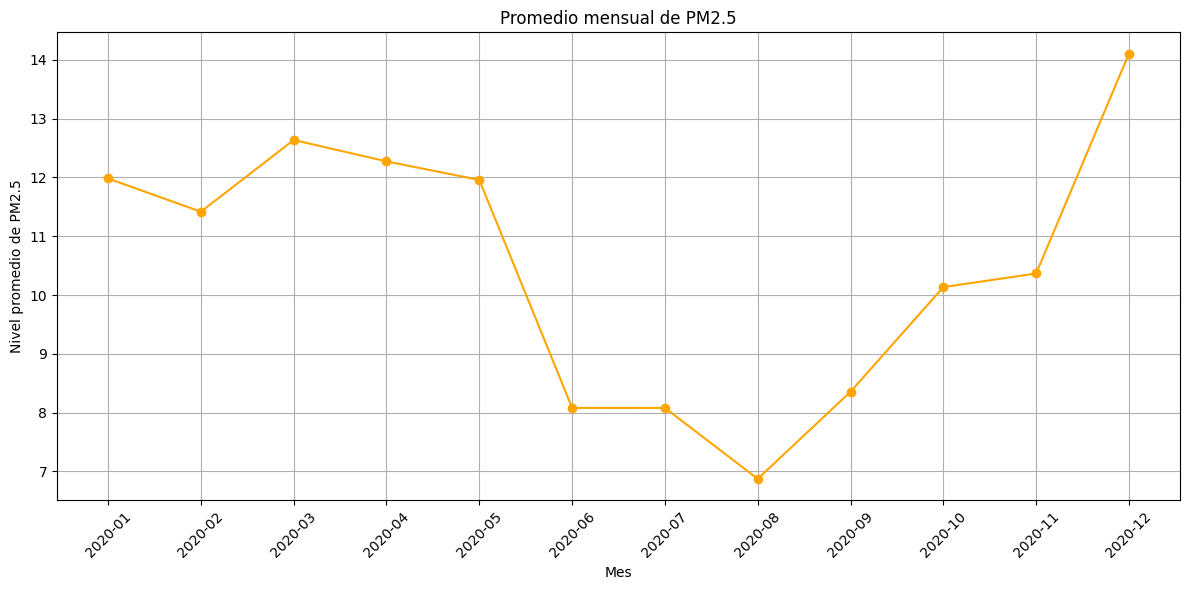

In [99]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "promedio_pm25_mensual": {
                "date_histogram": {
                    "field": "fc_lectura",
                    "calendar_interval": "month",
                    "format": "yyyy-MM"
                },
                "aggs": {
                    "pm25_avg": {
                        "avg": {
                            "field": "PM25"
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    # Extraer datos
    meses = []
    promedios = []
    for bucket in result['aggregations']['promedio_pm25_mensual']['buckets']:
        meses.append(bucket['key_as_string'])
        promedios.append(bucket['pm25_avg']['value'])

    # Crear DataFrame
    df = pd.DataFrame({
        "Mes": meses,
        "Promedio_PM25": promedios
    })
    # Graficar
    plt.figure(figsize=(12,6))
    plt.plot(df["Mes"], df["Promedio_PM25"], marker='o', color='orange')
    plt.xticks(rotation=45)
    plt.title("Promedio mensual de PM2.5")
    plt.xlabel("Mes")
    plt.ylabel("Nivel promedio de PM2.5")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Los resultados de la gráfica muestran una variación mensual significativa en los niveles promedio de PM2.5 durante el año 2020. Se observa que los meses con mayor concentración de partículas finas fueron diciembre (14.10 µg/m³), marzo (12.63 µg/m³) y abril (12.27 µg/m³), mientras que los valores más bajos se registraron entre junio y agosto, siendo agosto el mes con el promedio más bajo (6.87 µg/m³).

Esta distribución sugiere una posible influencia de factores estacionales y climáticos. Por ejemplo, en muchos entornos urbanos, los niveles de partículas tienden a aumentar en invierno debido a la menor dispersión atmosférica y al incremento en el uso de combustibles para calefacción. En cambio, en los meses de verano, una mayor ventilación y lluvias frecuentes pueden ayudar a reducir la concentración de contaminantes en el aire.

### Consulta 7: Dia con mayor concentración de PM10

Determinar el día con mayor concentración permite detectar eventos extremos de contaminación, que pueden estar relacionados con condiciones meteorológicas adversas, incendios, actividad industrial intensiva o alta concentración vehicular. Además, esta información es crucial para evaluar la efectividad de las políticas ambientales vigentes y entender mejor los factores que pueden detonar episodios críticos de mala calidad del aire.

In [103]:
with ElasticSearchProvider() as es:
    query = {
        "size": 1,
        "sort": [{"PM10": "desc"}]
    }

    result = es.connection.search(index=es.index, body=query)

    doc = result['hits']['hits'][0]['_source']
    print("Día con mayor concentración de PM10:")
    print(f"Fecha: {doc['fc_lectura']}, Hora: {doc['hora_lectura']}, PM10: {doc['PM10']}")


Día con mayor concentración de PM10:
Fecha: 2020-12-31, Hora: 24, PM10: 837.0


La concentración máxima de PM10 registrada el 31 de diciembre puede estar fuertemente influenciada por eventos específicos asociados a esta fecha, como la celebración de Año Nuevo. En muchas regiones, es común que durante la noche de fin de año se realicen actividades con uso intensivo de fuegos artificiales, los cuales generan una gran cantidad de partículas suspendidas en el aire, incluyendo PM10.

Además, durante esta fecha puede haber un aumento en la actividad vehicular y en la concentración de personas, factores que también contribuyen a la contaminación.


### Consulta 8: Promedio diario de O3

Esta consulta permite calcular el valor promedio diario del ozono (O3), un contaminante atmosférico que, aunque presente de forma natural, en concentraciones elevadas puede ser perjudicial para la salud humana y el medio ambiente.

El ozono troposférico es un contaminante secundario formado por reacciones fotoquímicas entre óxidos de nitrógeno (NOx) y compuestos orgánicos volátiles (COVs) en presencia de luz solar. Altos niveles de O3 pueden causar irritación respiratoria, agravar enfermedades pulmonares y afectar negativamente la vegetación.

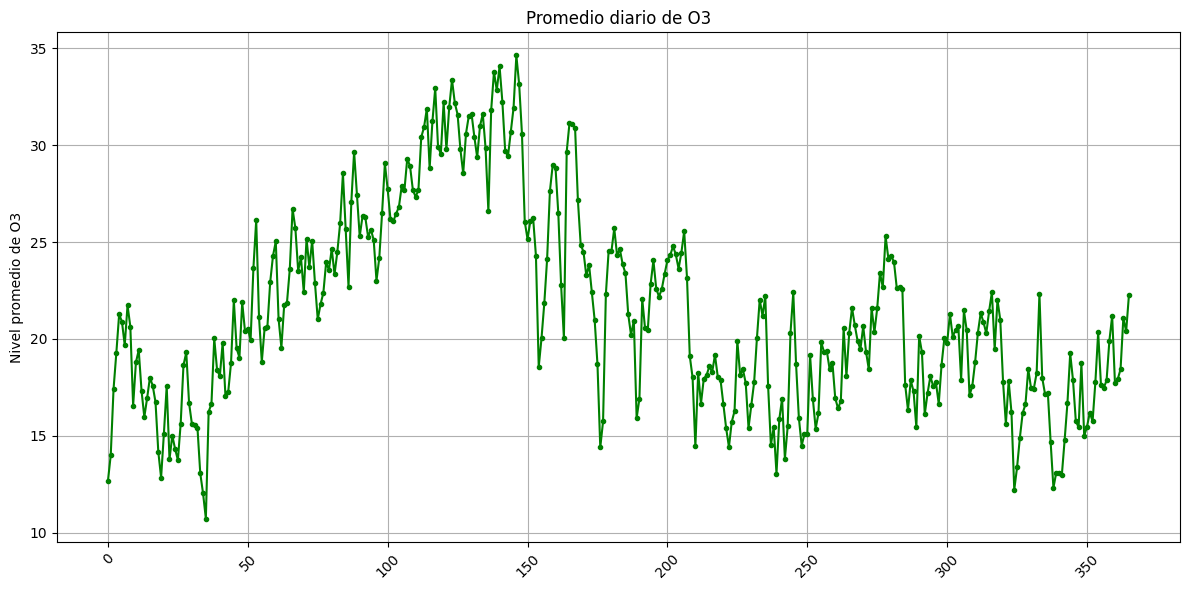

In [104]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "o3_diario": {
                "date_histogram": {
                    "field": "fc_lectura",
                    "calendar_interval": "day"
                },
                "aggs": {
                    "avg_o3": {
                        "avg": {
                            "field": "O3"
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    fechas = []
    promedios = []
    for bucket in result['aggregations']['o3_diario']['buckets']:
        fechas.append(bucket['key_as_string'])
        promedios.append(bucket['avg_o3']['value'])

    df = pd.DataFrame({"Fecha": fechas, "Promedio_O3": promedios})

    plt.figure(figsize=(12,6))
    plt.plot(df["Promedio_O3"], marker='.', color='green')
    plt.xticks(rotation=45)
    plt.title("Promedio diario de O3")
    plt.ylabel("Nivel promedio de O3")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Consulta 9: Comparación de NO2 entre estaciones (Primeras 10 estaciones)

Esta consulta busca comparar los niveles de dióxido de nitrógeno (NO2) entre las diferentes estaciones de monitoreo, con el fin de obtener una visión clara de la distribución espacial de este contaminante. El NO2 es un gas contaminante derivado principalmente de la combustión de combustibles fósiles, y está asociado con problemas de salud respiratoria y contaminación ambiental.

Los puntos clave que se pueden inferir de esta comparación incluyen:

- Identificación de las estaciones con mayores niveles de NO2, señalando posibles focos críticos de contaminación.
- Evaluación de la influencia de factores locales como el tráfico vehicular, zonas industriales y densidad urbana.
- Apoyo en la toma de decisiones para diseñar políticas ambientales específicas y focalizadas.

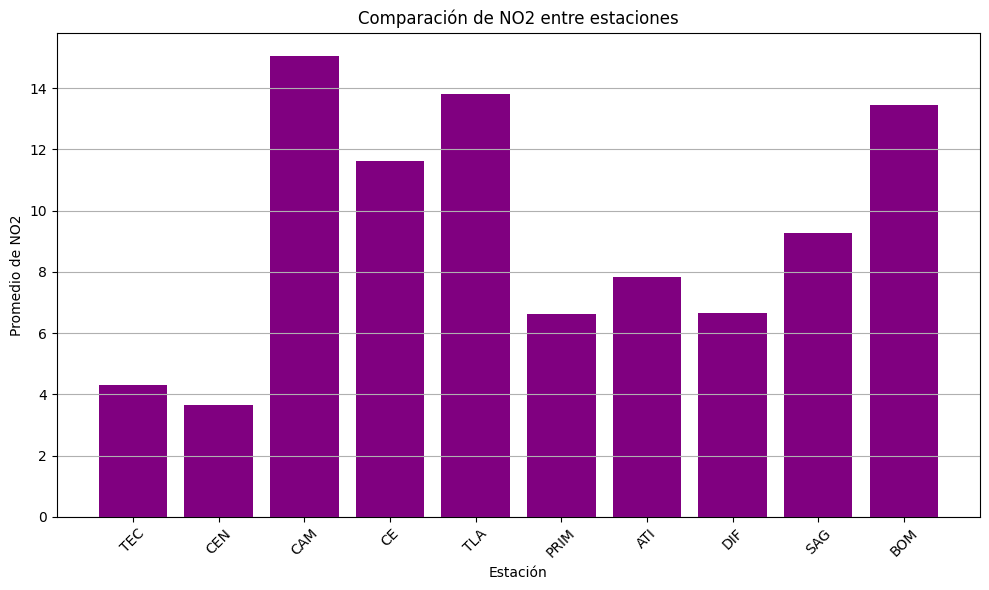

In [105]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "por_estacion": {
                "terms": {
                    "field": "estacion_id",
                    "size": 10
                },
                "aggs": {
                    "avg_no2": {
                        "avg": {
                            "field": "NO2"
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    estaciones = []
    promedios = []
    for bucket in result['aggregations']['por_estacion']['buckets']:
        estaciones.append(bucket['key'])
        promedios.append(bucket['avg_no2']['value'])

    df = pd.DataFrame({"Estación": estaciones, "Promedio_NO2": promedios})

    plt.figure(figsize=(10,6))
    plt.bar(df["Estación"], df["Promedio_NO2"], color='purple')
    plt.title("Comparación de NO2 entre estaciones")
    plt.xlabel("Estación")
    plt.ylabel("Promedio de NO2")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


Como observamos en la gráfica, el promedio de NO2 varía significativamente entre las estaciones analizadas. Destacan estaciones como CAM, TLA y BOM con concentraciones considerablemente más altas, lo que indica posibles fuentes locales de contaminación, como tráfico intenso o actividades industriales. En contraste, estaciones como TEC y CEN presentan niveles más bajos, sugiriendo áreas con mejor calidad del aire en términos de NO2.


### Consulta 10: Top 5 dias con mayor nivel de PM10 + PM25

Medir conjuntamente las partículas PM10 y PM25 es fundamental porque representan diferentes tamaños de partículas en suspensión que afectan la salud humana y el medio ambiente.

Las PM10 son partículas inhalables que pueden depositarse en las vías respiratorias superiores, mientras que las PM25, por ser más pequeñas, pueden penetrar profundamente en los pulmones y entrar en el torrente sanguíneo, causando problemas cardiovasculares y respiratorios graves.


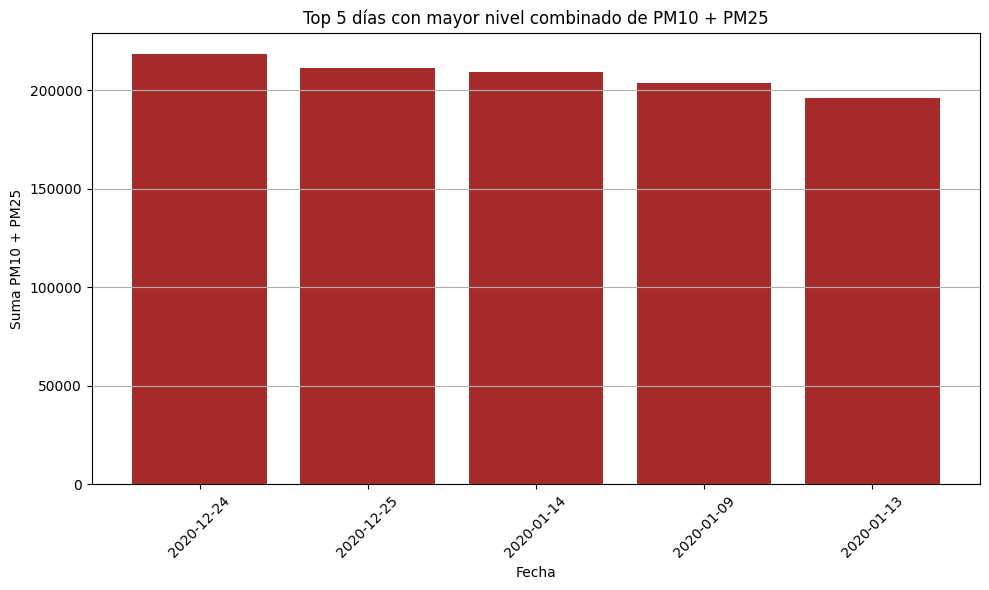

In [106]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "por_dia": {
                "date_histogram": {
                    "field": "fc_lectura",
                    "calendar_interval": "day"
                },
                "aggs": {
                    "suma_pm": {
                        "sum": {
                            "script": {
                                "source": "doc['PM10'].value + doc['PM25'].value",
                                "lang": "painless"
                            }
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    fechas = []
    sumas = []
    for bucket in result['aggregations']['por_dia']['buckets']:
        fechas.append(bucket['key_as_string'])
        sumas.append(bucket['suma_pm']['value'])

    df = pd.DataFrame({"Fecha": fechas, "Suma_PM10_PM25": sumas})
    df = df.sort_values(by="Suma_PM10_PM25", ascending=False).head(5)
    
    plt.figure(figsize=(10,6))
    plt.bar(df["Fecha"], df["Suma_PM10_PM25"], color='brown')
    plt.title("Top 5 días con mayor nivel combinado de PM10 + PM25")
    plt.xlabel("Fecha")
    plt.ylabel("Suma PM10 + PM25")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


Los resultados muestran que los días con mayores concentraciones combinadas de PM10 y PM2.5 ocurrieron principalmente en diciembre y enero, meses que coinciden con temporadas donde las condiciones meteorológicas suelen favorecer la acumulación de contaminantes, como temperaturas bajas y poca ventilación. Estos picos también pueden estar relacionados con actividades humanas específicas, como mayor uso de calefacción o eventos festivos que aumentan las emisiones contaminantes.

### Consulta 11: Media de contaminantes por red de monitoreo (Primeras 10 redes)

Esta consulta permite conocer el promedio de concentración de cada contaminante medido en las diferentes redes de monitoreo. Al analizar estos promedios, podemos identificar cuáles redes registran niveles más altos o bajos de contaminación, lo que refleja la calidad del aire en distintas regiones o zonas específicas. Esta información es clave para evaluar el desempeño y la efectividad de las políticas ambientales locales, así como para focalizar esfuerzos de mitigación en las áreas que presentan mayor riesgo para la salud pública.


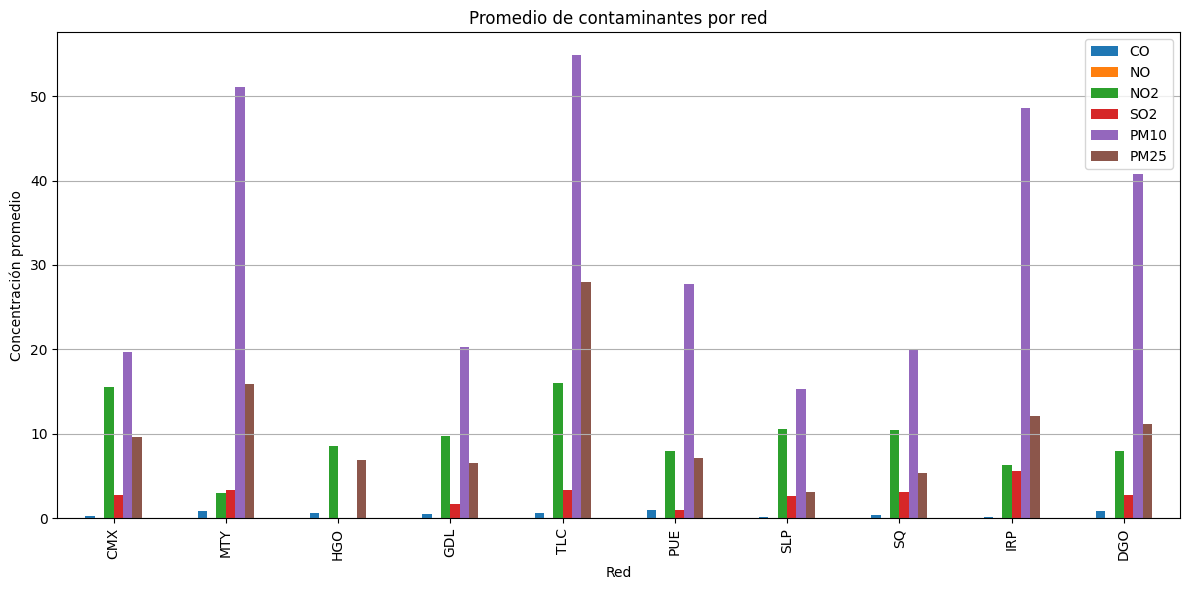

In [107]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "por_red": {
                "terms": {
                    "field": "red_id",
                    "size": 10
                },
                "aggs": {
                    "avg_co": {"avg": {"field": "CO"}},
                    "avg_no": {"avg": {"field": "NO"}},
                    "avg_no2": {"avg": {"field": "NO2"}},
                    "avg_so2": {"avg": {"field": "SO2"}},
                    "avg_pm10": {"avg": {"field": "PM10"}},
                    "avg_pm25": {"avg": {"field": "PM25"}},
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    red = []
    co = []
    no = []
    no2 = []
    so2 = []
    pm10 = []
    pm25 = []
    for bucket in result['aggregations']['por_red']['buckets']:
        red.append(bucket['key'])
        co.append(bucket['avg_co']['value'])
        no.append(bucket['avg_no']['value'])
        no2.append(bucket['avg_no2']['value'])
        so2.append(bucket['avg_so2']['value'])
        pm10.append(bucket['avg_pm10']['value'])
        pm25.append(bucket['avg_pm25']['value'])


    df = pd.DataFrame({
        "Red": red,
        "CO": co,
        "NO": no,
        "NO2": no2,
        "SO2": so2,
        "PM10": pm10,
        "PM25": pm25
    })
    
    df.set_index("Red").plot(kind='bar', figsize=(12,6))
    plt.title("Promedio de contaminantes por red")
    plt.ylabel("Concentración promedio")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


Como nos muestra la gráfica, la red TLC presenta los niveles más altos de PM10 y PM2.5, lo que indica una mayor presencia de partículas contaminantes en esa zona. Por otro lado, CMX, correspondiente a la Ciudad de México, muestra concentraciones elevadas de NO2, un contaminante vinculado principalmente al tráfico vehicular y actividades industriales. Redes como MTY y PUE también exhiben niveles considerables de PM10 y PM2.5, sugiriendo que estas áreas enfrentan retos importantes en el control de partículas finas.

### Consulta 12: Dia con mayor promedio total de contaminantes combinados

Esta consulta identifica el día con el nivel más alto de contaminación total al combinar todas las partículas y gases monitoreados, proporcionando un indicador clave para detectar episodios críticos de mala calidad del aire y tomar medidas oportunas de salud pública.

In [108]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "por_dia": {
                "date_histogram": {
                    "field": "fc_lectura",
                    "calendar_interval": "day"
                },
                "aggs": {
                    "avg_total": {
                        "avg": {
                            "script": {
                                "source": """
                                    (doc['CO'].value + doc['NO'].value + doc['NO2'].value + doc['O3'].value +
                                     doc['PM'].value + doc['PM10'].value + doc['PM25'].value + doc['SO2'].value) / 8
                                """,
                                "lang": "painless"
                            }
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    fechas = []
    promedios = []
    for bucket in result['aggregations']['por_dia']['buckets']:
        fechas.append(bucket['key_as_string'])
        promedios.append(bucket['avg_total']['value'])

    df = pd.DataFrame({
        "Fecha": fechas,
        "Promedio_Contaminantes": promedios
    })

    df_max = df.sort_values(by="Promedio_Contaminantes", ascending=False).head(1)
    display(df_max)


,Fecha,Promedio_Contaminantes
358,2020-12-24,14.193641


El día 24 de diciembre de 2020 presentó el mayor promedio total de contaminantes combinados, lo que indica un episodio significativo de contaminación atmosférica. Esto puede estar relacionado con actividades específicas de esa fecha (alta movilización de automoviles, calefaccion, etc), como aumentos en el uso de transporte o emisiones por festividades

### Consulta 13: Evolucion semanal del promedio de PM10 en estacion CMX

Filtrar la evolución semanal del promedio de PM10 específicamente en la estación CMX es relevante porque esta red monitorea una de las zonas urbanas más densamente pobladas y contaminadas del país, la Ciudad de México. Analizar esta información permite identificar patrones temporales y picos de contaminación particulares en esta área crítica, facilitando la implementación de políticas locales y estrategias efectivas para la mitigación de la contaminación y protección de la salud de sus habitantes.

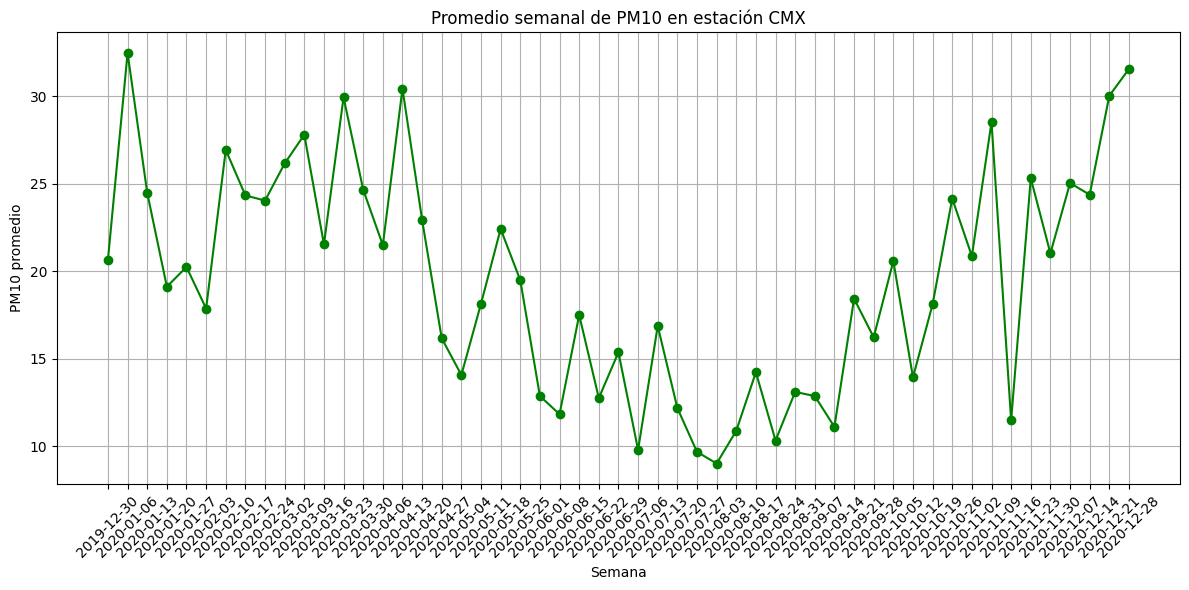

In [109]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "estacion_uno": {
                "filter": {
                    "term": {
                        "red_id": "CMX"
                    }
                },
                "aggs": {
                    "por_semana": {
                        "date_histogram": {
                            "field": "fc_lectura",
                            "calendar_interval": "week",
                            "format": "yyyy-MM-dd"
                        },
                        "aggs": {
                            "avg_pm10": {
                                "avg": {
                                    "field": "PM10"
                                }
                            }
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    semanas = []
    promedios = []
    # Acceder a los buckets correctamente dentro de la agregación anidada
    for bucket in result['aggregations']['estacion_uno']['por_semana']['buckets']:
        semanas.append(bucket['key_as_string'])
        promedios.append(bucket['avg_pm10']['value'])

    df = pd.DataFrame({
        "Semana": semanas,
        "Promedio_PM10": promedios
    })
    
    plt.figure(figsize=(12,6))
    plt.plot(df["Semana"], df["Promedio_PM10"], marker='o', color='green')
    plt.xticks(rotation=45)
    plt.title("Promedio semanal de PM10 en estación CMX")
    plt.xlabel("Semana")
    plt.ylabel("PM10 promedio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Este resultado muestra una fluctuación notable a lo largo del año, con picos claros en semanas como la primera de enero (32.48), mediados de marzo (29.94), abril (30.44), noviembre (28.53) y finales de diciembre (31.56). Estas variaciones pueden reflejar factores estacionales, condiciones climáticas y eventos específicos.

También es evidente una tendencia a la reducción de valores durante los meses de verano (junio a agosto), posiblemente por mejores condiciones de dispersión del aire. 

### Consulta 14: Registros con niveles de O3 superiores a 180

Esta consulta es fundamental para identificar episodios en los que los niveles de ozono (O3) superan los límites considerados seguros para la salud humana y el medio ambiente. Segun la OMS los valores superiores a 180 indican una contaminación atmosférica alta, lo cual puede causar serios problemas respiratorios, irritación ocular y agravar enfermedades pulmonares en la población. 

In [110]:
with ElasticSearchProvider() as es:
    query = {
        "query": {
            "range": {
                "O3": {
                    "gte": 180
                }
            }
        },
        "size": 1000,
        "_source": ["fc_lectura", "hora_lectura", "estacion_id", "O3"]
    }

    result = es.connection.search(index=es.index, body=query)

    fechas, horas, estaciones, niveles = [], [], [], []
    for hit in result['hits']['hits']:
        doc = hit['_source']
        fechas.append(doc['fc_lectura'])
        horas.append(doc['hora_lectura'])
        estaciones.append(doc['estacion_id'])
        niveles.append(doc['O3'])

    df = pd.DataFrame({
        "Fecha": fechas,
        "Hora": horas,
        "Estación": estaciones,
        "O3": niveles
    })

    display(df.head(10))


,Fecha,Hora,Estación,O3


El hecho de que no se hayan encontrado registros con niveles de O3 superiores a 180 puede interpretarse positivamente, ya que indica que durante el período analizado no se presentaron episodios de contaminación por ozono tan elevados como para superar ese umbral crítico. Esto sugiere que, al menos en términos de ozono, la calidad del aire se mantuvo dentro de límites relativamente seguros para la salud pública.

### Consulta 15: Porcentaje de los datos por red de monitoreo (Top 10 redes)

- Permite identificar qué redes de monitoreo contribuyen con la mayor cantidad de datos al conjunto total, lo que ayuda a entender la representatividad de cada red en el análisis general.  
- Facilita detectar posibles sesgos en la cobertura de datos si alguna red aporta pocos registros, lo que podría afectar la precisión de estudios o decisiones basadas en esos datos.  
- Ayuda a priorizar esfuerzos de mantenimiento o expansión en redes que tienen menor participación, mejorando así la calidad y cobertura del monitoreo ambiental.  
- Proporciona un panorama claro para la distribución espacial y temporal de los datos, esencial para estudios comparativos y análisis de tendencias ambientales.


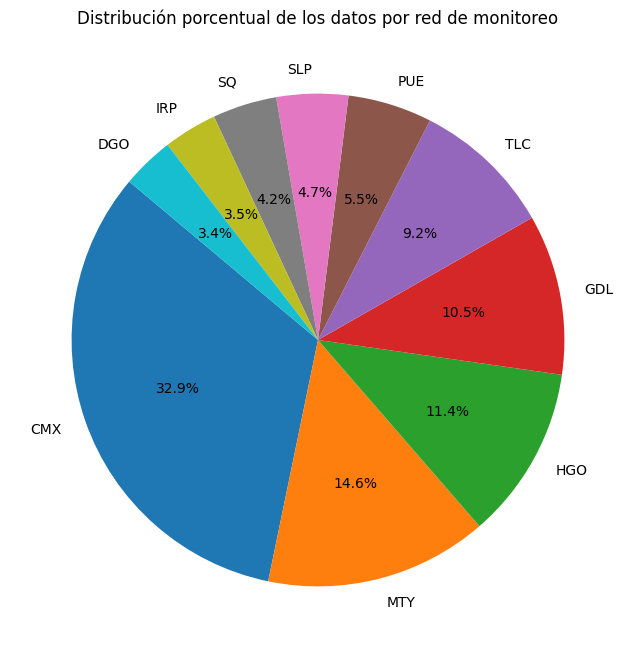

In [111]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "redes_monitoreo": {
                "terms": {
                    "field": "red_id",
                    "size": 10
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    redes = []
    porcentajes = []
    total_docs = result['hits']['total']['value']
    
    for bucket in result['aggregations']['redes_monitoreo']['buckets']:
        red = bucket['key']
        count = bucket['doc_count']
        porcentaje = (count / total_docs) * 100
        redes.append(red)
        porcentajes.append(porcentaje)

    # Crear DataFrame para fácil visualización
    df = pd.DataFrame({
        "Red de Monitoreo": redes,
        "Porcentaje": porcentajes
    })
    # Graficar con un gráfico de pastel
    plt.figure(figsize=(8, 8))
    plt.pie(df["Porcentaje"], labels=df["Red de Monitoreo"], autopct='%1.1f%%', startangle=140)
    plt.title("Distribución porcentual de los datos por red de monitoreo")
    plt.show()


La red CMX, correspondiente a la Ciudad de México, es la que contribuye con el mayor porcentaje, más del doble que la segunda red, MTY (Monterrey), lo que indica una mayor densidad o frecuencia de mediciones en esta área, probablemente debido a la complejidad y gravedad de la contaminación urbana en la capital. Las demás redes presentan porcentajes menores, con una distribución más equilibrada pero claramente menos representativa en comparación con CMX y MTY.

### Consulta 16: Concentración promedio de PM25 por hora
 
Esta consulta calcula la concentración promedio de partículas PM2.5 para cada hora del día, utilizando los datos registrados en las estaciones de monitoreo.

Conocer la variación horaria de PM2.5 es fundamental para identificar patrones de contaminación a lo largo del día, lo que permite establecer horarios críticos de exposición y diseñar políticas de mitigación más efectivas, especialmente en horas pico de tráfico o actividad industrial.


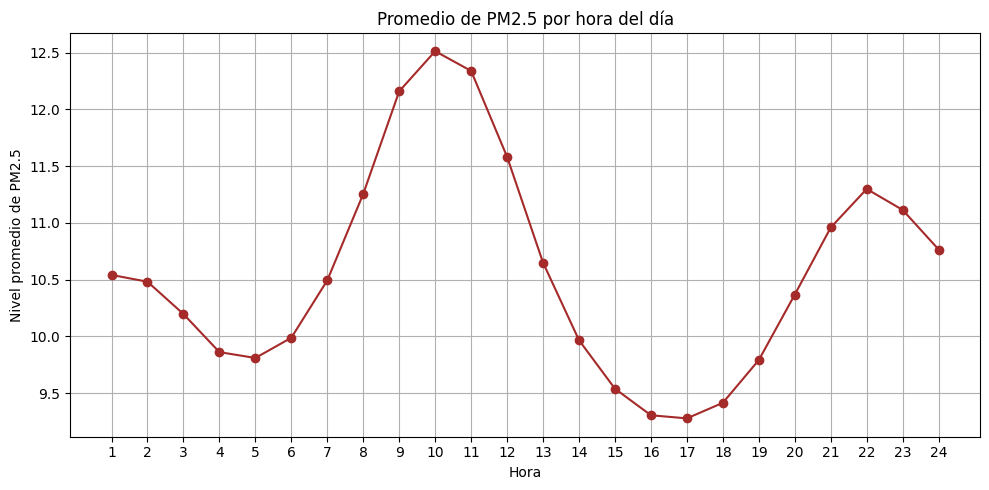

In [112]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs": {
            "promedio_por_hora": {
                "terms": {
                    "field": "hora_lectura",
                    "size": 24,
                    "order": {"_key": "asc"}
                },
                "aggs": {
                    "pm25_avg": {
                        "avg": {
                            "field": "PM25"
                        }
                    }
                }
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)

    horas = []
    promedios = []
    for bucket in result['aggregations']['promedio_por_hora']['buckets']:
        horas.append(bucket['key'])
        promedios.append(bucket['pm25_avg']['value'])

    df = pd.DataFrame({
        "Hora": horas,
        "Promedio_PM25": promedios
    })

    plt.figure(figsize=(10,5))
    plt.plot(df["Hora"], df["Promedio_PM25"], marker='o', color='brown')
    plt.xticks(df["Hora"])
    plt.title("Promedio de PM2.5 por hora del día")
    plt.xlabel("Hora")
    plt.ylabel("Nivel promedio de PM2.5")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Como nos muestra la gráfica, los datos muestran que la concentración promedio de PM2.5 presenta variaciones a lo largo del día, con valores más altos durante las horas matutinas (8 a 11 horas) y nuevamente en la noche (21 a 23 horas). Esto podría estar asociado a mayor actividad humana y tráfico vehicular en esos periodos, generando un incremento temporal en la contaminación del aire.

Estas variaciones horarias sugieren que las políticas de control ambiental podrían focalizarse en estas franjas para maximizar el impacto en la reducción de la exposición a contaminantes.
  

## Consulta 17: Top 10 de estaciones con mayores niveles promedio de SO2

Esta consulta identifica las 10 estaciones de monitoreo que registran los niveles promedio más altos de dióxido de azufre (SO2).
  
El SO2 es un contaminante asociado principalmente a la quema de combustibles fósiles y procesos industriales. Conocer las estaciones con mayores concentraciones permite focalizar esfuerzos de regulación, monitoreo y mitigación en áreas críticas, previniendo daños a la salud pública y al medio ambiente.

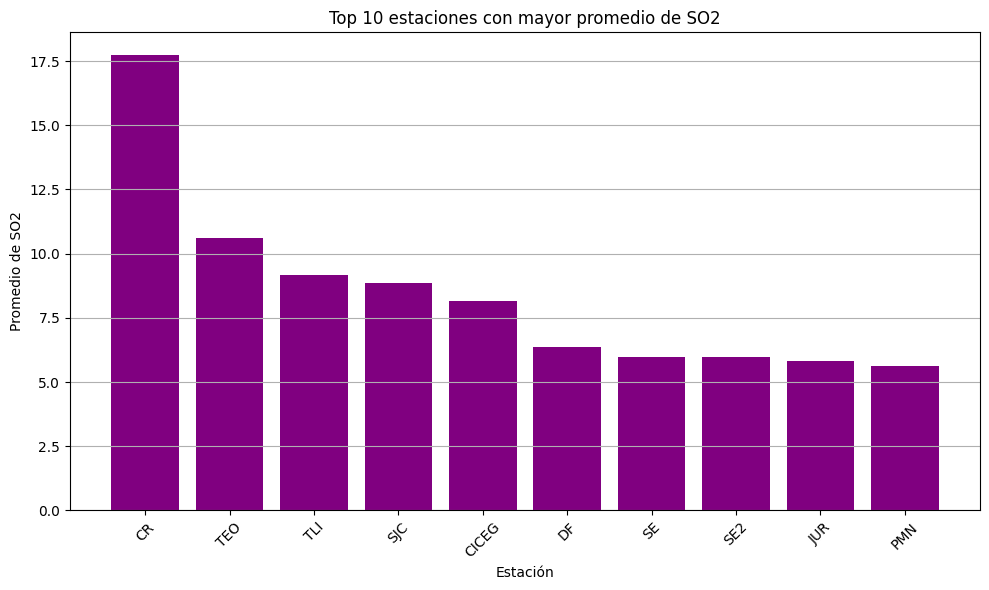

In [113]:
with ElasticSearchProvider() as es:
    query = {
        "size": 0,
        "aggs":{
            "por_estacion":{
                "terms":{
                    "field":"estacion_id",
                    "size":124
                },
                "aggs":{
                    "promedio_so2":{
                        "avg":{
                            "field":"SO2"
                        }
                    }
                }
                
            }
        }
    }

    result = es.connection.search(index=es.index, body=query)
    estaciones = []
    promedios = []

    for bucket in result['aggregations']['por_estacion']['buckets']:
        estaciones.append(bucket['key'])
        promedios.append(bucket['promedio_so2']['value'])

    df = pd.DataFrame({
        "Estación": estaciones,
        "Promedio_SO2": promedios
    })

    df = df.sort_values(by="Promedio_SO2", ascending=False).head(10)
    plt.figure(figsize=(10,6))
    plt.bar(df["Estación"], df["Promedio_SO2"], color='purple')
    plt.title("Top 10 estaciones con mayor promedio de SO2")
    plt.xlabel("Estación")
    plt.ylabel("Promedio de SO2")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

El análisis muestra que la estación CR presenta el nivel promedio más alto de SO2, con 17.73 unidades, seguida por TEO y TLI con niveles significativamente menores pero aún relevantes. Esto indica que en estas localidades la presencia de dióxido de azufre es más pronunciada, posiblemente debido a fuentes industriales o actividades que implican combustión de combustibles fósiles.

## 🔚 **Conclusión**

#### 📊 Consultas realizadas e información obtenida

A lo largo del análisis realizado, se llevaron a cabo **17 consultas clave** sobre un conjunto de datos que contiene más de un millón de registros relacionados con la calidad del aire en México durante el año 2020. Estas consultas no solo permitieron identificar patrones de comportamiento en los contaminantes atmosféricos, sino también generar interpretaciones útiles y con sentido contextual.

Se exploraron aspectos relevantes como la cantidad de estaciones por red de monitoreo, la distribución de registros, los promedios mensuales y diarios de contaminantes específicos como PM2.5, PM10, O3 y NO2, así como la identificación de días críticos con altos niveles de contaminación. Este enfoque permitió identificar, por ejemplo, que **la Ciudad de México (CMX)** es la red con mayor infraestructura de monitoreo, así como los posibles efectos estacionales y festivos (como el 31 de diciembre) en la calidad del aire.

Gracias a estas consultas, fue posible construir una narrativa clara sobre **cómo varía la contaminación a lo largo del tiempo y el espacio**, facilitando una base sólida para la toma de decisiones ambientales, el diseño de políticas públicas y la identificación de áreas críticas que requieren mayor atención.

---


#### ⚙️ Uso de Elasticsearch como herramienta de análisis

Elasticsearch demostró ser una herramienta altamente eficaz para manejar grandes volúmenes de datos, permitiendo una exploración rápida, flexible y detallada del conjunto de registros. Su capacidad para realizar **búsquedas complejas, agregaciones y análisis temporales** fue esencial para responder preguntas relevantes de manera eficiente.

La integración con entornos como **Jupyter Notebook** facilitó la automatización de consultas, la visualización de resultados y la generación de interpretaciones contextualizadas. Esto permitió una transición fluida entre el análisis técnico y la comunicación efectiva de hallazgos.

---

### 🌱 Importancia y Aplicabilidad

La contaminación atmosférica tiene un impacto directo en la salud humana, los ecosistemas y el cambio climático. Este trabajo ofrece una base técnica útil para:

- Formular **políticas públicas de control ambiental** más focalizadas y basadas en evidencia.
- Informar a la población sobre **horarios y zonas de mayor riesgo**.
- Apoyar investigaciones futuras en áreas de salud ambiental, urbanismo o modelado predictivo.

Finalmente, la integración de ciencia de datos con herramientas de monitoreo ambiental puede ser una poderosa aliada para la sostenibilidad urbana, la equidad ambiental y la mejora de la calidad de vida.


